# Unsupervised Learning - Dimensionality Reduction

Exploring my database by creating two-dimensional maps of my embeddings.

In [16]:
#Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from umap import UMAP
from hdbscan import HDBSCAN
from nomic import atlas
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation, MeanShift
from sklearn.cluster import SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

warnings.filterwarnings('ignore')
pd.set_option('max_colwidth', 100)
plt.style.use("ggplot")

In [17]:
#Imports from project package called project_tools
from project_tools.utils import adapt_array, convert_array, table_loader

In [18]:
#Register these functions with sqlite3 so that we I can work with 
sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

#Connect to db
conn = sqlite3.connect("../jaage.db", detect_types= sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()

In [19]:
with open("nomic_api_key.txt") as  f:
    nomic_key = f.read()

Show tables

In [20]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
tables

[('effnet_embeddings',),
 ('tonal_features',),
 ('lowlevel_features',),
 ('rhythm_features',),
 ('approachability_2c_effnet_discogs_1_activations',),
 ('danceability_effnet_discogs_1_activations',),
 ('engagement_2c_effnet_discogs_1_activations',),
 ('genre_electronic_effnet_discogs_1_activations',),
 ('mood_acoustic_effnet_discogs_1_activations',),
 ('mood_aggressive_effnet_discogs_1_activations',),
 ('mood_happy_effnet_discogs_1_activations',),
 ('mood_party_effnet_discogs_1_activations',),
 ('mood_sad_effnet_discogs_1_activations',),
 ('mtg_jamendo_genre_effnet_discogs_1_activations',),
 ('mtg_jamendo_moodtheme_effnet_discogs_1_activations',),
 ('mtg_jamendo_top50tags_effnet_discogs_1_activations',),
 ('timbre_effnet_discogs_1_activations',),
 ('lowlevel_barkbands_mean_tbl',),
 ('lowlevel_barkbands_stdev_tbl',),
 ('lowlevel_erbbands_mean_tbl',),
 ('lowlevel_erbbands_stdev_tbl',),
 ('lowlevel_gfcc_mean_tbl',),
 ('lowlevel_melbands_mean_tbl',),
 ('lowlevel_melbands_stdev_tbl',),
 ('lo

Load in the genres, tags, and mood/style data.

I plan to use this data to color the maps 

In [21]:
tags = table_loader(conn, "SELECT * FROM TAGS", apply_function=None)
genres = table_loader(conn, "SELECT * FROM effnet_genres", apply_function=lambda x:x[0].mean())

keep_gcols = np.load("../keep_genre_cols.pkl", allow_pickle=True).tolist()
genres = genres[keep_gcols]

In [22]:
mood_queries = ["SELECT sid, danceable FROM danceability_effnet_discogs_1_activations",
          "SELECT sid, approachable FROM approachability_2c_effnet_discogs_1_activations",
          "SELECT sid, engaging FROM engagement_2c_effnet_discogs_1_activations",
          "SELECT sid, acoustic FROM mood_acoustic_effnet_discogs_1_activations",
          "SELECT sid, aggressive FROM mood_aggressive_effnet_discogs_1_activations",
          "SELECT sid, happy FROM mood_happy_effnet_discogs_1_activations",
          "SELECT sid, sad FROM mood_sad_effnet_discogs_1_activations",
          "SELECT sid, party FROM mood_party_effnet_discogs_1_activations",
            "SELECT sid, bright FROM timbre_effnet_discogs_1_activations"]

mood_scores = table_loader(conn,*mood_queries, apply_function=lambda x:x[0].mean())

In [23]:
effnet_embeddings = table_loader(conn, "SELECT * FROM effnet_embeddings", 
                                 apply_function = lambda x:x[0].mean(axis=0))
effnet_embeddings = effnet_embeddings.effnet_embedding.apply(pd.Series)

In [24]:
mule_embeddings = pd.read_pickle("../music-audio-representations/pandora_embeddings.pkl")
mule_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727
b806881a54bdbf9dd93a290716adf191,-0.081668,0.075497,0.264657,0.149692,-0.198961,-0.040836,-0.149892,-0.037577,0.155324,0.172994,...,-0.081464,0.083890,0.080812,0.074434,-0.109267,-0.021827,-0.000377,-0.004791,0.097056,0.030002
46e54d2ab920a088b77382e04877141b,-0.024848,0.302505,0.023536,-0.052920,-0.223651,-0.071047,-0.244511,-0.132367,0.232674,0.019792,...,-0.104152,0.113786,0.268650,0.087452,-0.106190,-0.042744,0.040515,-0.056856,0.100844,0.000626
a204ddef5763df6d8f7677701fe9d96f,-0.042381,0.039526,0.259096,0.178754,-0.256650,0.066121,0.028585,0.145469,0.192028,0.230999,...,-0.045840,0.126162,-0.062732,0.003037,-0.118569,-0.073403,0.071981,-0.016371,0.052373,-0.041562
960097894e83c5810a9c649f17a4e551,-0.069410,-0.030149,0.407555,-0.029317,-0.257356,-0.035079,-0.066160,-0.063945,0.156475,0.036290,...,-0.096784,0.083452,0.207477,0.055262,-0.120177,-0.036175,0.038606,-0.013567,0.112138,0.077642
a3c1f277aa0110ffc418bf5fa3aa16aa,-0.149835,-0.060183,0.086029,-0.206231,-0.214728,-0.076708,-0.022723,-0.079100,0.192175,-0.038374,...,-0.020232,0.065714,0.019031,0.019224,-0.066259,-0.048618,0.013458,-0.009333,0.057584,0.004177


In [25]:
# mfcc = pd.read_sql_query("SELECT * FROM lowlevel_mfcc_mean_tbl", con = conn).set_index("sid")
# mfcc.head()

In [26]:
jamendo_moodtheme = table_loader(conn, 
                                 "SELECT * FROM mtg_jamendo_moodtheme_effnet_discogs_1_activations",
                           apply_function = lambda x:x[0].mean())

jamendo_top50tags = table_loader(conn, "SELECT * FROM mtg_jamendo_top50tags_effnet_discogs_1_activations",
                                apply_function = lambda x:x[0].mean())

In [27]:
jamendo_top50tags.mean().nlargest(15)

electronic       0.398067
synthesizer      0.269108
house            0.239684
chillout         0.212226
pop              0.194865
dance            0.166733
guitar           0.164281
bass             0.158875
drums            0.141780
keyboard         0.130378
piano            0.111459
easylistening    0.090277
funk             0.087384
happy            0.082252
lounge           0.077811
dtype: float32

## Outline


- 1. Effnet Embeddings

- 2. Pandora Embeddings

In [28]:
class DimRedHub:

    def __init__(self, data ):
        self.data = data        
        self.dr_data = {}

    def reducer(self, algorithm):
        
        
        algorithm = algorithm
        dr_data = algorithm.fit_transform(self.data)
        dr_data = pd.DataFrame(index = self.data.index, data = dr_data, columns=["component1", "component2"])
        algo_name = algorithm.__class__.__name__
        
        self.dr_data[algo_name] = dr_data
        
        
    def visualize(self, algorithm, figsize = (8, 5), color = None,  **plot_kws):
                
        if algorithm == "all":
            
            pca_data = self.dr_data["PCA"]
            tsne_data = self.dr_data["TSNE"]
            umap_data = self.dr_data["UMAP"]
            
            if color is not None:
            
                pca_data = pca_data.join(color)
                tsne_data = tsne_data.join(color)
                umap_data = umap_data.join(color)
                
                color = pca_data[color.name]
                
                
                
            
            fig, axs = plt.subplots(1, 3, figsize = figsize)

            axs[0].set_title("PCA Data Visualized")
            sb.scatterplot(x = pca_data.component1, 
                           y = pca_data.component2,
                           ax = axs[0],
                           hue = color,
                           
                           **plot_kws)
            axs[0].xaxis.grid(False)
            
            
            axs[1].set_title("TSNE Data Visualized")
            sb.scatterplot(x = tsne_data.component1, 
                           y = tsne_data.component2,
                           ax = axs[1],
                           hue = color,
                           **plot_kws)
            axs[1].xaxis.grid(False)
            
            
            axs[2].set_title("UMAP Data Visualized")
            sb.scatterplot(x = umap_data.component1, 
                           y = umap_data.component2,
                           ax = axs[2],
                           hue = color,
                           **plot_kws)
            axs[2].xaxis.grid(False);
        
        else:
        
            data = self.dr_data[algorithm]
            x = data["component1"]
            y = data["component2"]
            
            if color is not None:
                data = data.join(color)
                color = data[color.name]
            
            plt.figure(figsize=figsize)
            plt.title("{} Data Visualize".format(algorithm))
            sb.scatterplot(x = x, 
                           y = y,
                           hue = color,
                            **plot_kws)
            plt.xlabel("Component 1")
            plt.ylabel("Component 2")
            plt.grid(False);
    

In [37]:
RANDOM_STATE = 1

### Effnet Embeddings

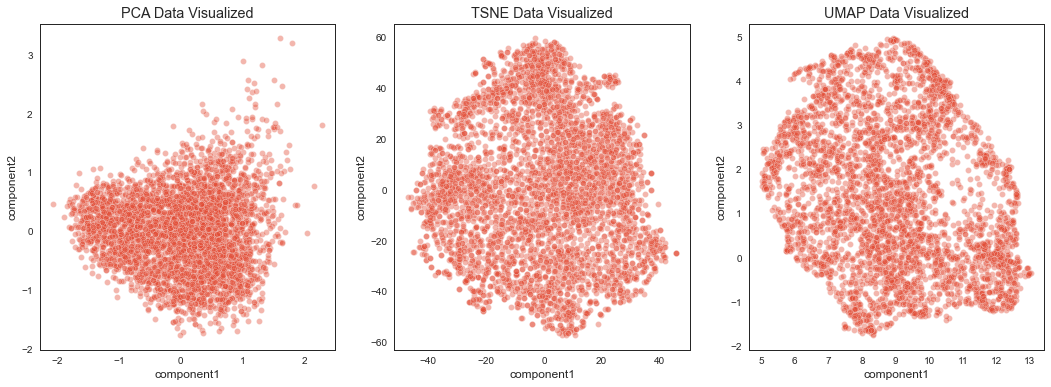

In [38]:
effnet = DimRedHub(effnet_embeddings)
effnet.reducer(PCA(n_components=2, random_state=RANDOM_STATE))
effnet.reducer(TSNE(n_components=2, perplexity=50, metric = "cosine", random_state=RANDOM_STATE))
effnet.reducer(UMAP(n_components=2, n_neighbors = 30, metric = "cosine", random_state=RANDOM_STATE))
effnet.visualize(algorithm = "all", figsize = (18, 6), alpha = .4)

### Pandora Mule Embeddings

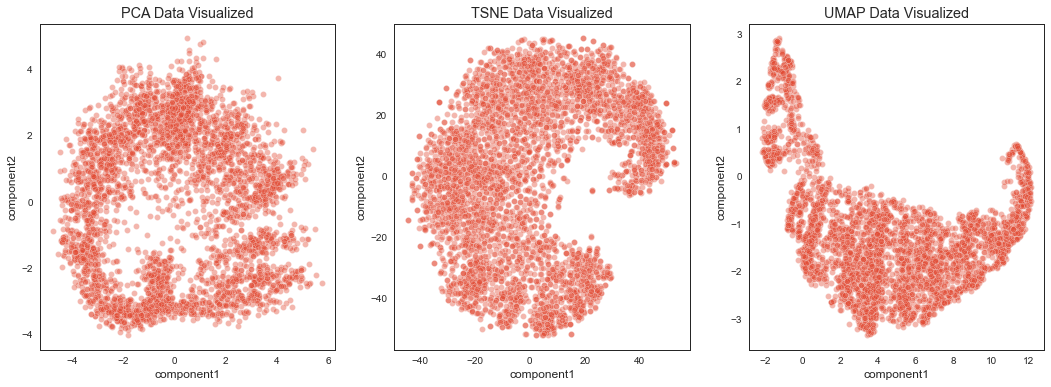

In [39]:

pandora = DimRedHub(mule_embeddings)
pandora.reducer(PCA(n_components=2, random_state=RANDOM_STATE))
pandora.reducer(TSNE(n_components=2, perplexity = 50, random_state=RANDOM_STATE))
pandora.reducer(UMAP(n_components=2, n_neighbors = 30, metric = "cosine",random_state=RANDOM_STATE))
pandora.visualize(algorithm = "all", figsize = (18, 6), alpha = .4)

#### Color by genres and mood/style

Grab the color data

In [32]:
##genres
edisco = genres["electronic___disco"]
house = genres["electronic___house"]
funk = genres["funk__soul___funk"]
funk_disco  = genres["funk__soul___disco"]

#moods

approach = mood_scores["approachable"]
happy = mood_scores["happy"]

party = mood_scores["party"]
energetic = jamendo_moodtheme["energetic"]

Connect hue data with the embeddings

In [40]:
pandora_umap = pandora.dr_data["UMAP"].join(edisco)
pandora_umap = pandora_umap.join(house)
pandora_umap = pandora_umap.join(funk)
pandora_umap = pandora_umap.join(funk_disco)
pandora_umap = pandora_umap.join(approach)
pandora_umap = pandora_umap.join(happy)
pandora_umap = pandora_umap.join(party)
pandora_umap = pandora_umap.join(energetic)


**Genre Mappings**

<AxesSubplot:xlabel='component1', ylabel='component2'>

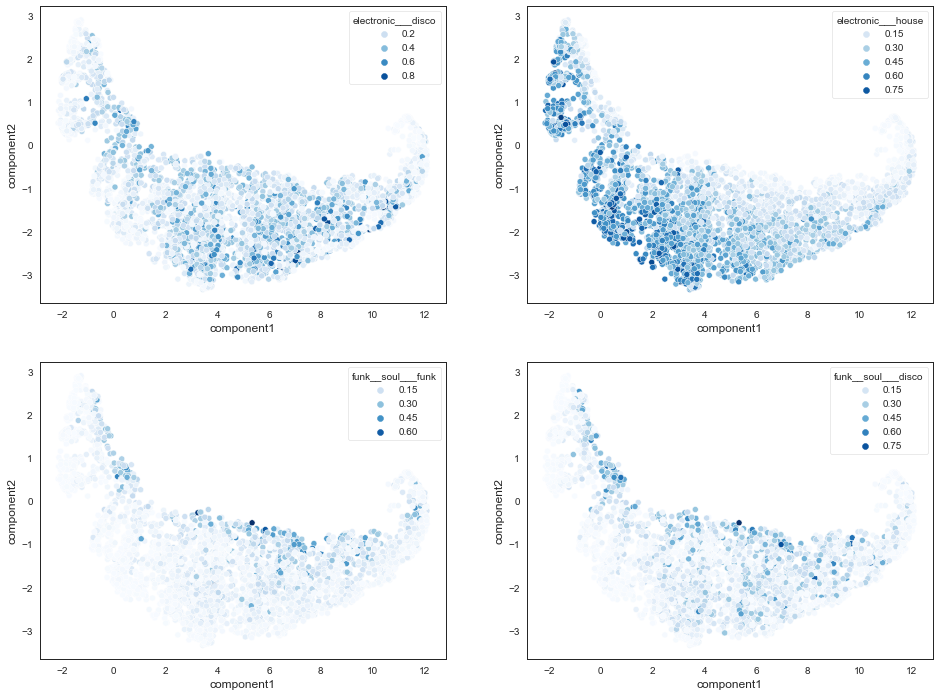

In [41]:
fig, axes = plt.subplots(ncols=2, nrows = 2, figsize = (16, 12))
x = "component1"
y = "component2"
palette = "Blues"

hue_norm = lambda x:(x.min(), x.max())

sb.scatterplot(x = x, y = y, hue="electronic___disco",
               data = pandora_umap, ax = axes[0][0], 
               palette=palette, hue_norm=hue_norm(pandora_umap["electronic___disco"]))

sb.scatterplot(x = x, y = y, hue="electronic___house",
               data = pandora_umap, ax = axes[0][1], 
               palette=palette, hue_norm=hue_norm(pandora_umap["electronic___house"]))

sb.scatterplot(x = x, y = y, hue="funk__soul___funk",
               data = pandora_umap, ax = axes[1][0], 
               palette=palette, hue_norm=hue_norm(pandora_umap["funk__soul___funk"]))

sb.scatterplot(x = x, y = y, hue="funk__soul___disco",
               data = pandora_umap, ax = axes[1][1], 
               palette=palette, hue_norm=hue_norm(pandora_umap["funk__soul___disco"]))

Mood mappings

<AxesSubplot:xlabel='component1', ylabel='component2'>

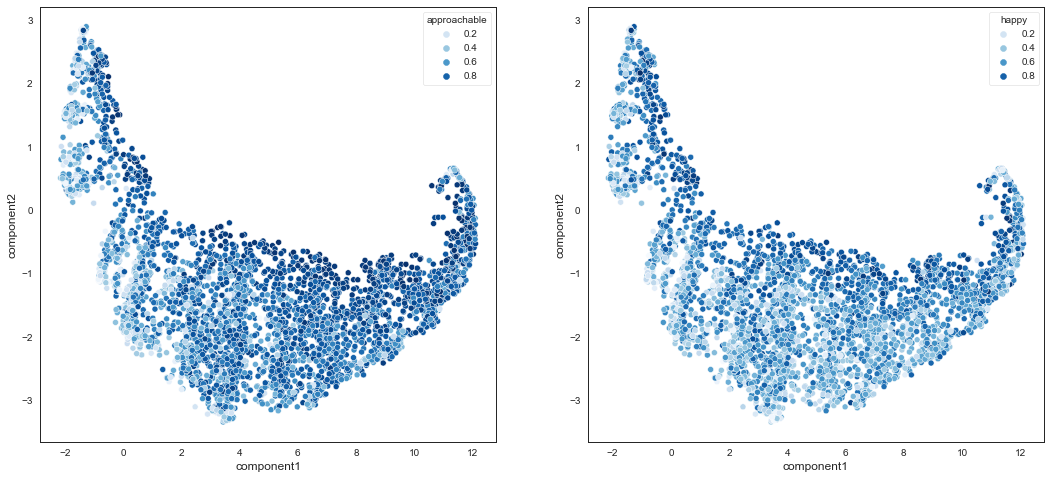

In [42]:
fig, axes = plt.subplots(ncols=2, nrows = 1, figsize = (18, 8))

sb.scatterplot(x = x, y = y, hue="approachable",
               data = pandora_umap, ax = axes[0],
               palette=palette, hue_norm=hue_norm(pandora_umap["approachable"]))

sb.scatterplot(x = x, y = y, hue="happy",
               data = pandora_umap, ax = axes[1], 
               palette=palette, hue_norm=hue_norm(pandora_umap["happy"]))

### Nomic Interactive embeddings

Visualizing embeddings in a 2D space is much more fun when it's interactive. That's I'm using the Nomic package, which makes its own 2D embeddings from my data in its interactive visualization.

The Nomic plots will allow me to explore an interactive display of my data. I'll be able to reveal information about songs by hovering over them and the scatter plot dots will also be also be color-encoded by genre.

Prepare the genre data

In [44]:

top6_genres = genres.mean().nlargest(6).index.tolist()

genres = genres[top6_genres]
genres.head()

,electronic___house,electronic___disco,electronic___nu_disco,electronic___deep_house,funk__soul___disco,funk__soul___funk
sid,,,,,,
b806881a54bdbf9dd93a290716adf191,0.414671,0.233615,0.219446,0.242627,0.099939,0.023430
46e54d2ab920a088b77382e04877141b,0.319738,0.007987,0.003889,0.083245,0.000999,0.002191
a204ddef5763df6d8f7677701fe9d96f,0.255668,0.127695,0.361088,0.219225,0.035980,0.015550
960097894e83c5810a9c649f17a4e551,0.306436,0.086445,0.007725,0.038853,0.010388,0.011354
a3c1f277aa0110ffc418bf5fa3aa16aa,0.021689,0.075877,0.036910,0.012459,0.067594,0.145519


In [46]:
genres.idxmax(axis =1).value_counts()

electronic___house         2056
electronic___disco          709
electronic___nu_disco       538
funk__soul___funk           240
funk__soul___disco          166
electronic___deep_house     107
dtype: int64

In [47]:
genre_labels = genres.idxmax(axis =1).rename("genre")

In [48]:
info = tags[["title", "artist"]]

#### Effnet

In [49]:
effnet_atlas_df = pd.concat([effnet_embeddings, genre_labels, info], axis = 1)

In [50]:
label_data = []


for i in range(effnet_atlas_df.shape[0]):
    artist = effnet_atlas_df.iloc[i]["artist"]
    title = effnet_atlas_df.iloc[i]["title"]
    genre = effnet_atlas_df.iloc[i]["genre"]
    iD = effnet_atlas_df.index[i]
    
    out = {"artist":artist, "title": title, "genre":genre, "id":iD}
    label_data.append(out)

In [51]:
project = atlas.map_embeddings(embeddings=effnet_embeddings.values, data = label_data,
                               name = "Effnet Embeddings",
                              id_field="id", colorable_fields=["genre"], reset_project_if_exists=True)

2023-05-18 11:47:04.643 | INFO     | nomic.project:__init__:849 - Found existing project `Effnet Embeddings` in organization `geo.mcintire`. Clearing it of data by request.
2023-05-18 11:47:06.135 | INFO     | nomic.project:_create_project:938 - Creating project `Effnet Embeddings` in organization `geo.mcintire`
2023-05-18 11:47:07.333 | INFO     | nomic.atlas:map_embeddings:98 - Uploading embeddings to Atlas.
4it [00:02,  1.67it/s]                                                                                                                       
2023-05-18 11:47:09.757 | INFO     | nomic.atlas:map_embeddings:117 - Embedding upload succeeded.
2023-05-18 11:47:10.341 | INFO     | nomic.project:create_index:1248 - Created map `Effnet Embeddings` in project `Effnet Embeddings`: https://atlas.nomic.ai/map/1298a926-987a-4afd-88ad-d9bb10a7308c/5bedc4c7-61da-41ea-a82c-41f47e241487
2023-05-18 11:47:10.342 | INFO     | nomic.atlas:map_embeddings:130 - Effnet Embeddings: https://atlas.nomic.a

View the interactive map at:

https://atlas.nomic.ai/map/2180fe53-1c1e-4471-aaa2-49a1144040e0/641f53f6-db83-424b-88de-9b090e1c32e5


#### Pandora Mule

In [52]:
mule_atlas_df = pd.concat([mule_embeddings, genre_labels, info], axis = 1, join = "inner")

In [53]:
label_data = []


for i in range(mule_atlas_df.shape[0]):
    artist = mule_atlas_df.iloc[i]["artist"]
    title = mule_atlas_df.iloc[i]["title"]
    genre = mule_atlas_df.iloc[i]["genre"]
    iD = mule_atlas_df.index[i]
    
    out = {"artist":artist, "title": title, "genre":genre, "id":iD}
    label_data.append(out)

In [54]:
project = atlas.map_embeddings(embeddings=mule_atlas_df.iloc[:, :-3].values, data = label_data,
                               name = "Pandora Mule Embeddings",
                              id_field="id", colorable_fields=["genre"], reset_project_if_exists=True)

2023-05-18 11:47:23.087 | INFO     | nomic.project:__init__:849 - Found existing project `Pandora Mule Embeddings` in organization `geo.mcintire`. Clearing it of data by request.
2023-05-18 11:47:24.255 | INFO     | nomic.project:_create_project:938 - Creating project `Pandora Mule Embeddings` in organization `geo.mcintire`
2023-05-18 11:47:25.474 | INFO     | nomic.atlas:map_embeddings:98 - Uploading embeddings to Atlas.
4it [00:01,  2.37it/s]                                                                                                                       
2023-05-18 11:47:27.204 | INFO     | nomic.atlas:map_embeddings:117 - Embedding upload succeeded.
2023-05-18 11:47:27.686 | INFO     | nomic.project:create_index:1248 - Created map `Pandora Mule Embeddings` in project `Pandora Mule Embeddings`: https://atlas.nomic.ai/map/26433856-c50f-42a3-a80d-8bed239414ec/a006cc34-c8e8-450c-9ab2-08cefe8f0ee1
2023-05-18 11:47:27.686 | INFO     | nomic.atlas:map_embeddings:130 - Pandora Mule Emb

Visualize map here:

https://atlas.nomic.ai/map/658d57e5-c159-46d8-a0ab-61c73c9d2cee/3850996a-3cb7-4cab-8d28-cae7511d6f2b